In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [6]:
def object_detection(model_img_path, target_img_path, MIN_MATCH_COUNT=10, visualize=True):
    """Detect if the given object (i.e. model image) is contained in the given target image.

    The model object is detected in the target image if at least `MIN_MATCH_COUNT` corresponding keypoints are found between
    the two images.
    
    The two images are assumed to be greyscale.

    Parameters
    ----------
    model_img_path : str
        Path of the model image (i.e. object of interest)
    target_img_path : str
        Path of the target image
    MIN_MATCH_COUNT : int, optional
        Minimum number of matched corresponding points for saying that the object has been detected, by default 10
    visualize : bool, optional
        Whether to visualize or not the bounding box surrounding the object in the target image, by default True

    Returns
    -------
    corners_bounding_box: np.array
        Array containing the four points representing the object bounding box in the target image.
        If no object has been detected, `corners_bounding_box` is None
        
    """
    model_img = cv2.imread(model_img_path,cv2.IMREAD_GRAYSCALE)
    target_img = cv2.imread(target_img_path,cv2.IMREAD_GRAYSCALE)
    
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # KEYPOINTS of the model image, found wiht SIFT
    kp_model = sift.detect(model_img)
    # KEYPOINTS of the target image, found wiht SIFT
    kp_target = sift.detect(target_img)
    
    # `des_query` contains the DESCRIPTORS of the keypoints computed on the model image (SIFT descriptors).
    kp_model, des_model = sift.compute(model_img, kp_model)

    # `des_train` contains the DESCRIPTORS of the keypoints computed on the target image (SIFT descriptors)
    kp_target, des_target = sift.compute(target_img, kp_target)
    
    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1
    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)
    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching and finding the 2 closest target keypoints for each query keypoint.
    matches = flann.knnMatch(des_model, des_target, k=2)
    
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)
            
    if len(good_matches)>MIN_MATCH_COUNT:  # FOUND ENOUGH NUMBER OF GOOD MATCHES: THE OBJECT HAS BEEN DETECTED
        
        # building the corrspondences arrays of good matches
        src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_target[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        # Using RANSAC to estimate a robust homography. 
        # It returns the homography M and a mask for the discarded points
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Mask of discarded point used in visualization
        matchesMask = mask.ravel().tolist()

        # Corners of the query image
        h, w = model_img.shape
        corners_model_img = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

        # Projecting the corners into the train image
        corners_bounding_box = cv2.perspectiveTransform(corners_model_img, M)

        # Drawing the bounding box
        target_img = cv2.polylines(target_img, [np.int32(corners_bounding_box)], True, 255, 3, cv2.LINE_AA)
        
        if visualize:
            plt.figure()
            plt.imshow(target_img, 'gray')
            plt.title('Target image with the bounding box surrounding the object of interest')
        
        return corners_bounding_box
    
    else:  # NOT FOUND ENOUGH NUMBER OF GOOD MATCHES: THE OBJECT HAS NOT BEEN DETECTED
        print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
        return None

In [9]:
object_detection(model_img_path='barcode_model.jpg', target_img_path='images/EAN128-CONTRAST IMGB.bmp', 
                 MIN_MATCH_COUNT=2, visualize=True)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'


In [11]:
!pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=e36f9b129386d7e509e98c99eac1d4e818f129cd07364be90c1866d260eb1e8a
  Stored in directory: c:\users\pitti\appdata\local\pip\cache\wheels\59\1b\52\0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils


In [1]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [7]:
image_path = 'images/C39_4.4LOW.bmp'

(1024, 1280, 3)


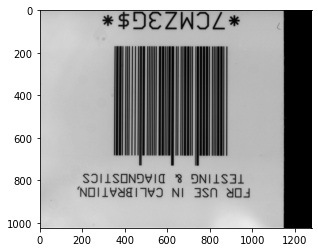

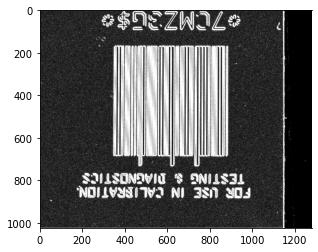

In [22]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')

# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

plt.figure()
plt.imshow(gradient, 'gray')

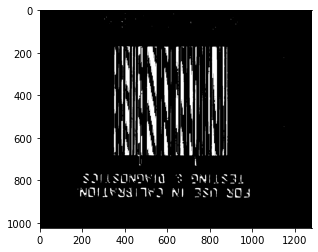

In [23]:
# blur and threshold the image
blurred = cv2.blur(gradient, (9, 9))
(_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

plt.figure()
plt.imshow(thresh, 'gray')

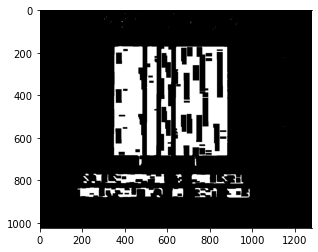

In [24]:
# construct a closing kernel and apply it to the thresholded image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed, 'gray')

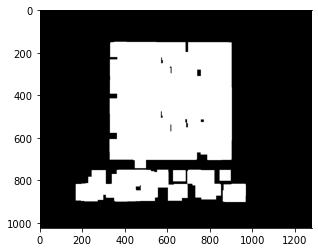

In [25]:
# perform a series of erosions and dilations
closed = cv2.erode(closed, None, iterations = 4)
closed = cv2.dilate(closed, None, iterations = 25)

plt.figure()
plt.imshow(closed, 'gray')

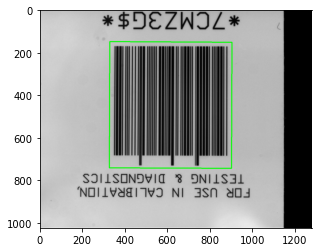

In [26]:
# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
# draw a bounding box arounded the detected barcode and display the
# image

image_bb = image.copy()
cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_bb, 'gray')

In [27]:
box

array([[326, 741],
       [328, 148],
       [903, 151],
       [901, 743]], dtype=int64)

In [28]:
print(src_pts)
print(dst_pts)

[[326. 741.]
 [328. 148.]
 [903. 151.]
 [901. 743.]]
[[   0. 1023.]
 [   0.    0.]
 [1279.    0.]
 [1279. 1023.]]


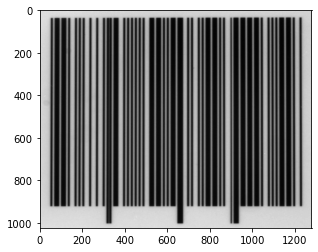

In [29]:
h = 1024
w = 1280

src_pts = box.astype('float32')
dst_pts = np.array([[0,h-1], [0,0],[w-1,0], [w-1,h-1]],
dtype = "float32")
H = cv2.getPerspectiveTransform(src_pts, dst_pts)

image1 = cv2.warpPerspective(gray, H, (w, h))

plt.imshow(image1, 'gray')

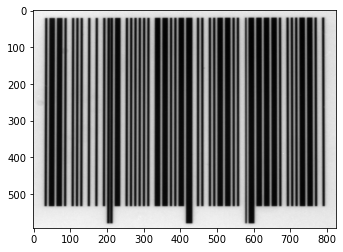

In [30]:
h = 1024
w = 1280

coordinates_source = box.astype('float32')

def dist(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))
destination_height = int(max([dist(coordinates_source[0],coordinates_source[1]),
                         dist(coordinates_source[2],coordinates_source[3])]))
destination_width = int(max([dist(coordinates_source[0],coordinates_source[2]),
                         dist(coordinates_source[1],coordinates_source[3])]))
coordinates_destination = np.array([[0, destination_height-1],
                                    [0, 0], 
                                    [destination_width-1, 0],
                                    [destination_width-1, destination_height-1]], dtype='float32')

# Computing the trasformation, i.e. homography. Warping.
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation
gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))

plt.imshow(gray1, 'gray')

In [31]:
np.logical_and(gray<255, gray>0)

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

In [5]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [67]:
image_path = 'images/EAN-UPC-EAN-13 MASTER GRADE IMGB.bmp' # C39_4.4LOW  C39_7.5UP  EAN128-DEFECTS IMGB  EAN128-MASTER IMGB  EAN-UPC-EAN-13 MASTER GRADE IMGB

(1024, 1280, 3)


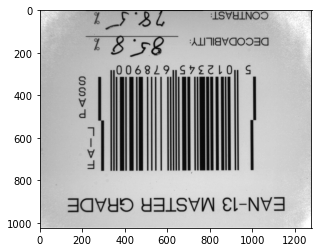

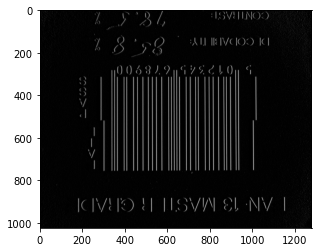

In [68]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')

# Find contours
kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
image_horizontal_derivative = cv2.filter2D(gray, -1, kernel_horizontal_derivative)
image_horizontal_derivative = np.abs(image_horizontal_derivative)
kernel_vertical_derivative = 1/4 * np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
image_vertical_derivative = cv2.filter2D(gray, -1, kernel_vertical_derivative)
image_vertical_derivative = np.abs(image_vertical_derivative)

image_derivative = np.maximum(image_horizontal_derivative, image_vertical_derivative)

plt.figure()
plt.imshow(image_horizontal_derivative, 'gray')

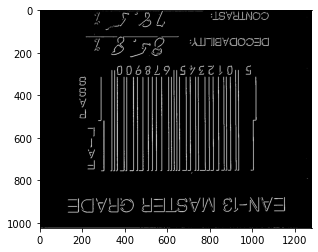

In [69]:
# Threshold, Otsu's algorithm
ret2,thresh = cv2.threshold(image_derivative,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure()
plt.imshow(thresh, 'gray')

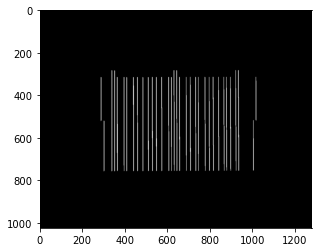

In [70]:
# Keep only vertical bars
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opened, 'gray')

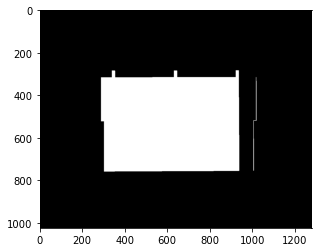

In [73]:
# OPTION A: closing
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed, 'gray')

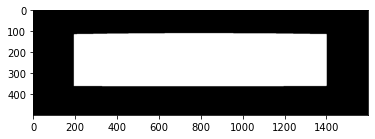

In [66]:
# Option B : dilation
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 100))
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))

dilated = cv2.dilate(opened, None, iterations = 30)

plt.figure()
plt.imshow(dilated, 'gray')

In [41]:
print(cv2. __version__)

4.6.0


In [38]:
def apply_dilation(opened):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 100))

    dilated = cv2.dilate(opened, None, iterations = 1)
    
    while True:
        im2, contours = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print(im2)
        print()
        print(contours.shape)
        """cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print(cnts)
        cnts = imutils.grab_contours(cnts)
        c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
        # compute the rotated bounding box of the largest contour
        rect = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
        box = np.int0(box)
        #print(box)
        
        dilated_bb = dilated.copy() 
        #cv2.cvtColor(dilated_bb, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(dilated_bb, [box], 0, 255, 3)
        plt.figure()
        plt.imshow(dilated_bb)
        
        box = sorted([tuple(coords) for coords in box])
        print(box)
        
        sub_dilated = dilated[box[0][1]:box[1][1], box[0][0]:box[2][0]]
        #print(sub_dilated.shape)"""
        
        """opened_bb = opened.copy() 
        opened_bb = opened_bb[box[0][1]:box[1][1], box[0][0]:box[2][0]]
        plt.figure()
        plt.imshow(opened_bb)"""
        
        """foreground_dilated = dilated.sum()
        foreground_dilated_sub = sub_dilated.sum()
        print(foreground_dilated)
        print(foreground_dilated_sub)
        
        if foreground_dilated_sub/foreground_dilated>0.9:
            break
            
        dilated = cv2.dilate(dilated, None, iterations = 1)"""
        
        break
        
    return dilated
        

In [39]:
dilated = apply_dilation(opened)

(array([[[1044,  275]],

       [[1044,  791]],

       [[1047,  791]],

       [[1047,  790]],

       [[1048,  789]],

       [[1048,  328]],

       [[1047,  327]],

       [[1047,  275]]], dtype=int32), array([[[1030,  275]],

       [[1030,  791]],

       [[1033,  791]],

       [[1033,  790]],

       [[1034,  789]],

       [[1034,  382]],

       [[1033,  381]],

       [[1033,  275]]], dtype=int32), array([[[981, 275]],

       [[981, 791]],

       [[983, 791]],

       [[984, 790]],

       [[984, 789]],

       [[985, 788]],

       [[985, 366]],

       [[984, 365]],

       [[984, 275]]], dtype=int32), array([[[967, 275]],

       [[967, 791]],

       [[969, 791]],

       [[970, 790]],

       [[970, 772]],

       [[971, 771]],

       [[971, 316]],

       [[970, 315]],

       [[970, 275]]], dtype=int32), array([[[1069,  274]],

       [[1068,  275]],

       [[1068,  791]],

       [[1071,  791]],

       [[1072,  790]],

       [[1072,  275]],

       [[1071,  274

In [173]:
abs(202930020-204000000)

1069980

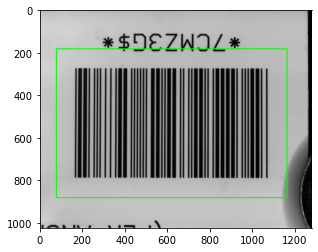

In [28]:
# Bounding box

# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(cnts)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
# draw a bounding box arounded the detected barcode and display the
# image

image_bb = image.copy()
cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_bb, 'gray')

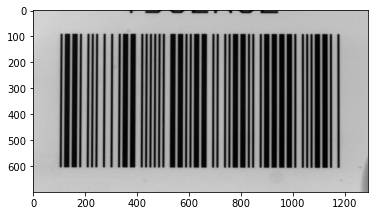

In [30]:
h = 1024
w = 1280

coordinates_source = box.astype('float32')

def dist(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))
destination_height = int(max([dist(coordinates_source[0],coordinates_source[1]),
                         dist(coordinates_source[2],coordinates_source[3])]))
destination_width = int(max([dist(coordinates_source[0],coordinates_source[2]),
                         dist(coordinates_source[1],coordinates_source[3])]))
coordinates_destination = np.array([[0, destination_height-1],
                                    [0, 0], 
                                    [destination_width-1, 0],
                                    [destination_width-1, destination_height-1]], dtype='float32')

# Computing the trasformation, i.e. homography. Warping.
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation
gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))

plt.imshow(gray1, 'gray')

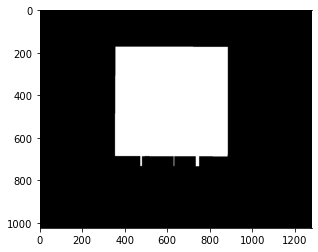

In [83]:
# construct a closing kernel and apply it to the thresholded image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))
closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed, 'gray')

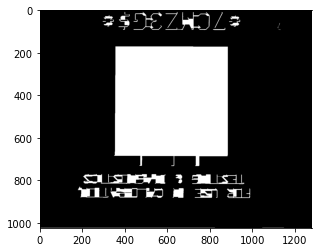

In [73]:
# construct a closing kernel and apply it to the thresholded image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 2))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed, 'gray')

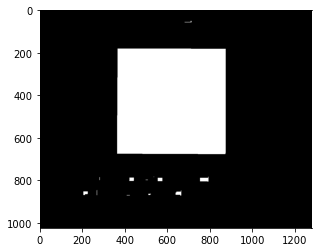

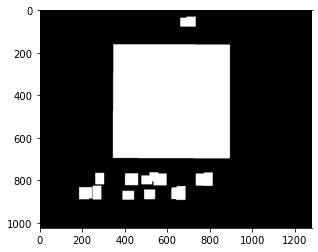

In [74]:
# perform a series of erosions and dilations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))

closed = cv2.erode(closed, None, iterations = 10)

plt.figure()
plt.imshow(closed, 'gray')

closed = cv2.dilate(closed, None, iterations = 20)

plt.figure()
plt.imshow(closed, 'gray')

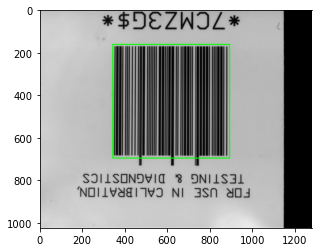

In [75]:
# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
# draw a bounding box arounded the detected barcode and display the
# image

image_bb = image.copy()
cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_bb, 'gray')

In [62]:
box

array([[326, 741],
       [328, 148],
       [903, 151],
       [901, 743]], dtype=int64)

In [63]:
print(src_pts)
print(dst_pts)

[[326. 741.]
 [328. 148.]
 [903. 151.]
 [901. 743.]]
[[   0. 1023.]
 [   0.    0.]
 [1279.    0.]
 [1279. 1023.]]


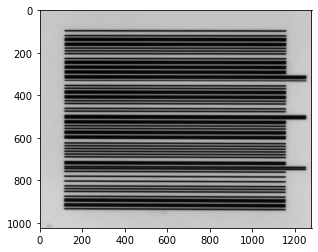

In [66]:
h = 1024
w = 1280

src_pts = box.astype('float32')
dst_pts = np.array([[0,h-1], [0,0],[w-1,0], [w-1,h-1]],
dtype = "float32")
H = cv2.getPerspectiveTransform(src_pts, dst_pts)

image1 = cv2.warpPerspective(gray, H, (w, h))

plt.imshow(image1, 'gray')

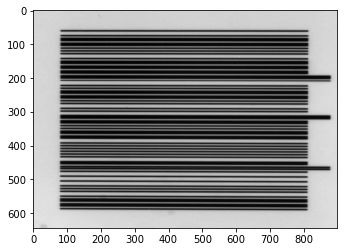

In [67]:
h = 1024
w = 1280

coordinates_source = box.astype('float32')

def dist(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))
destination_height = int(max([dist(coordinates_source[0],coordinates_source[1]),
                         dist(coordinates_source[2],coordinates_source[3])]))
destination_width = int(max([dist(coordinates_source[0],coordinates_source[2]),
                         dist(coordinates_source[1],coordinates_source[3])]))
coordinates_destination = np.array([[0, destination_height-1],
                                    [0, 0], 
                                    [destination_width-1, 0],
                                    [destination_width-1, destination_height-1]], dtype='float32')

# Computing the trasformation, i.e. homography. Warping.
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation
gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))

plt.imshow(gray1, 'gray')

In [66]:
np.logical_and(gray<255, gray>0)

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])